# Simple Baseline Analysis for Positive Bag MIL Model
# 복수 작성자 필기 문서에서 서로 다른 작성자의 윈도우를 간단하게 시각화하는 베이스라인

이 노트북은 학습된 AttentionMIL 모델에서 Positive로 예측된 bag의 attention 패턴을 **한 장 그림**으로 간단하게 분석합니다.
복잡한 통계 분석 대신, 실제 필기 이미지를 통해 "다른 손"을 직관적으로 확인하는 것이 목적입니다.

In [1]:
# 1. 환경 설정 및 필요 라이브러리 임포트

import os
import sys
import pickle
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from tqdm import tqdm
from scipy.stats import kendalltau, spearmanr
from sklearn.metrics import accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 시드 고정
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 이미지 경로 설정
IMAGE_BASE_DIR = '/workspace/MIL/data/raw/csafe_version5_xai_train'

Using device: cuda


In [2]:
# 2. 모델 정의 (stage3_baseline-positiveBag-fixed.ipynb와 동일)

class AttentionMIL_WithStats(nn.Module):
    """
    기존 AttentionMIL에 bag-level 통계를 추가한 개선 모델
    """
    def __init__(self, input_dim=256, hidden_dim=128, dropout=0.1):
        super().__init__()
        # Instance embedding
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        # Attention mechanism
        self.att_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.att_fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
        # Classifier with extended features
        # bag_repr(H) + mu(H) + var(H) + d_mean(1) = 3H + 1
        self.classifier = nn.Sequential(
            nn.Linear(3*hidden_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        self._init_weights()
        
    def _init_weights(self):
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu')
        nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att_fc1.weight)
        nn.init.zeros_(self.att_fc1.bias)
        nn.init.xavier_uniform_(self.att_fc2.weight)
        nn.init.zeros_(self.att_fc2.bias)
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # 1) Instance transformation
        H = torch.relu(self.instance_fc(x))  # (B, N, H)
        
        # 2) Attention weights
        A = self.att_fc2(torch.tanh(self.att_fc1(H))).squeeze(-1)  # (B, N)
        W = torch.softmax(A, dim=1)
        
        # 3) Weighted bag representation
        bag_repr = torch.sum(W.unsqueeze(-1) * H, dim=1)  # (B, H)
        
        # 4) Statistical features for set-level heterogeneity
        mu  = H.mean(dim=1)                               # (B, H) - 평균
        var = H.var(dim=1, unbiased=False)                # (B, H) - 분산
        d_mean = torch.cdist(H, H, p=2).mean(dim=(1,2))   # (B,) - 평균 쌍거리
        
        # 5) Concatenate all features
        z = torch.cat([bag_repr, mu, var, d_mean.unsqueeze(-1)], dim=-1)  # (B, 3H+1)
        z = self.dropout(z)
        
        # 6) Classification
        logits = self.classifier(z).squeeze(-1)
        return logits, W

In [3]:
# 3. 데이터 로드 (메타데이터 처리 수정)

# Bag 데이터 로드
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{embedding_margin}_50p_random_test.pkl')

print('Loading test bag data...')
with open(test_pkl, 'rb') as f:
    test_data = pickle.load(f)

# Instance mean 계산 함수
def to_instance_means(bags):
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

test_features = to_instance_means(test_data['bags'])
test_labels = test_data['labels']

# 메타데이터 처리 - test_data에 metadata가 포함되어 있는지 확인
if 'metadata' in test_data:
    metadata = test_data['metadata']
    print('Metadata found in bag data')
else:
    # 메타데이터가 없으면 빈 딕셔너리로 초기화
    print('Warning: No metadata found. Creating empty metadata.')
    metadata = [{} for _ in range(len(test_labels))]
    
    # 작성자 정보를 임시로 생성 (실제 작성자 ID가 없으므로 시뮬레이션)
    # Positive bag은 두 작성자, Negative bag은 한 작성자
    for i in range(len(test_labels)):
        if test_labels[i] == 1:  # Positive (forged)
            # 복수 작성자 시뮬레이션
            metadata[i] = {
                'instances': [
                    {'writer_ids': [i % 100] * 5, 'word_paths': []} if j < 5 
                    else {'writer_ids': [(i+50) % 100] * 5, 'word_paths': []}
                    for j in range(10)
                ]
            }
        else:  # Negative (genuine)
            # 단일 작성자
            metadata[i] = {
                'instances': [
                    {'writer_ids': [i % 100] * 5, 'word_paths': []}
                    for j in range(10)
                ]
            }

print(f'Test bags: {len(test_labels)}')
print(f'Positive bags: {sum(test_labels)}, Negative bags: {len(test_labels) - sum(test_labels)}')

# 학습된 모델 로드
model_path = 'best_attention_mil_withstats.pth'
print(f'Loading trained model from {model_path}...')

model = AttentionMIL_WithStats(input_dim=256, hidden_dim=128, dropout=0.1).to(device)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    print('Model loaded successfully!')
else:
    print(f'Warning: Model file {model_path} not found. Using random initialization.')
    
model.eval()

Loading test bag data...
Metadata found in bag data
Test bags: 1200
Positive bags: 600, Negative bags: 600
Loading trained model from best_attention_mil_withstats.pth...
Model loaded successfully!


AttentionMIL_WithStats(
  (instance_fc): Linear(in_features=256, out_features=128, bias=True)
  (att_fc1): Linear(in_features=128, out_features=128, bias=True)
  (att_fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=385, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [4]:
# 4. 초간단 베이스라인 시각화 함수들 (fix.md 드롭인 코드)

def _predict_att(model, bag_tensor):
    model.eval()
    with torch.no_grad():
        x = torch.tensor(bag_tensor, dtype=torch.float32).unsqueeze(0).to(device)
        logits, att = model(x)
        prob = torch.sigmoid(logits).item()
        att = att.squeeze(0).detach().cpu().numpy()
    return prob, att

def _writer_of_instance(inst_meta):
    # 순수 윈도우 세팅이라 writer_ids[0]이면 충분
    if 'writer_ids' in inst_meta and inst_meta['writer_ids']:
        return inst_meta['writer_ids'][0]
    return None

def _writer_palette(wA, wB, w):
    if w == wA: return 'blue', 'A'
    if w == wB: return 'red',  'B'
    return 'gray', 'U'

def _draw_instance_row(inst_meta, color, title, image_base, axarr):
    # inst_meta['word_paths'] 길이 5 가정, 없으면 placeholder
    paths = inst_meta.get('word_paths', [])
    for k in range(5):
        ax = axarr[k]
        fp = os.path.join(image_base, paths[k]) if (paths and k < len(paths) and paths[k]) else None
        if fp and os.path.exists(fp):
            try:
                img = Image.open(fp).convert('RGB')
                ax.imshow(img)
            except:
                ax.text(0.5,0.5,f'W{k+1}',ha='center',va='center'); ax.set_facecolor('#e0e0e0')
        else:
            ax.text(0.5,0.5,f'W{k+1}',ha='center',va='center'); ax.set_facecolor('#f5f5f5')
        for sp in ax.spines.values():
            sp.set_edgecolor(color); sp.set_linewidth(3)
        ax.set_xticks([]); ax.set_yticks([])
    axarr[0].set_ylabel(title, rotation=0, ha='right', va='center', fontsize=10)

def pick_positive_bag_indices(model, features, labels, metadata, threshold=0.5, topn=1):
    # 예측이 Positive(=정답 1, 예측 1)인 bag 중 확률 높은 순
    probs = []
    for i in range(len(labels)):
        p,_ = _predict_att(model, features[i])
        probs.append(p)
    probs = np.array(probs)
    correct_pos = [i for i in range(len(labels)) if labels[i]==1 and probs[i]>=threshold]
    if not correct_pos: return []
    order = np.argsort(probs[correct_pos])[::-1]
    return [correct_pos[i] for i in order[:topn]]

def quick_positive_report(bag_idx, model, features, labels, metadata,
                          image_base=IMAGE_BASE_DIR, threshold=0.5, save_dir='quick_reports'):
    os.makedirs(save_dir, exist_ok=True)
    bag = features[bag_idx]            # (10, D) — instance means
    meta = metadata[bag_idx]           # instances/word_paths 포함
    prob, att = _predict_att(model, bag)

    # 작성자 두 명 파악
    writers = []
    for inst in meta.get('instances', []):
        w = _writer_of_instance(inst)
        if w is not None: writers.append(w)
    uniq = list(dict.fromkeys(writers))[:2]  # 보이는 순서로 2명
    if len(uniq) < 2:
        print(f"[Bag {bag_idx}] 두 작성자 식별 실패(메타 부족)."); return

    wA, wB = uniq[0], uniq[1]

    # 각 작성자별 attention Top-1 인덱스 선택
    idxA = [i for i,inst in enumerate(meta['instances']) if _writer_of_instance(inst)==wA]
    idxB = [i for i,inst in enumerate(meta['instances']) if _writer_of_instance(inst)==wB]
    if not idxA or not idxB:
        print(f"[Bag {bag_idx}] 두 작성자 윈도우가 충분치 않음."); return
    topA = idxA[int(np.argmax(att[idxA]))]
    topB = idxB[int(np.argmax(att[idxB]))]

    # 그림 구성
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Bag #{bag_idx}  True=Forged, Pred={'Forged' if prob>=threshold else 'Genuine'}  "
                 f"(p={prob:.3f}, thr={threshold:.2f})", fontsize=12, fontweight='bold')

    # 1행: Writer A
    ax_row1 = [plt.subplot(2,5,1+k) for k in range(5)]
    colorA, tagA = _writer_palette(wA,wB,wA)
    _draw_instance_row(meta['instances'][topA], colorA,
                       title=f"Writer {tagA}  inst={topA}  att={att[topA]:.3f}",
                       image_base=image_base, axarr=ax_row1)

    # 2행: Writer B
    ax_row2 = [plt.subplot(2,5,6+k) for k in range(5)]
    colorB, tagB = _writer_palette(wA,wB,wB)
    _draw_instance_row(meta['instances'][topB], colorB,
                       title=f"Writer {tagB}  inst={topB}  att={att[topB]:.3f}",
                       image_base=image_base, axarr=ax_row2)

    plt.tight_layout(rect=[0,0,1,0.92])
    out_path = os.path.join(save_dir, f"bag_{bag_idx}_A_vs_B.png")
    plt.savefig(out_path, dpi=150, bbox_inches='tight'); plt.show()
    print(f"✓ saved: {out_path}")

print("✓ 간단한 베이스라인 함수들이 로드되었습니다.")

✓ 간단한 베이스라인 함수들이 로드되었습니다.


🔍 확신 높은 Positive bag 자동 선택 후 한 장 리포트 생성...
선택된 bag: 215 (확률 높은 Positive bag)


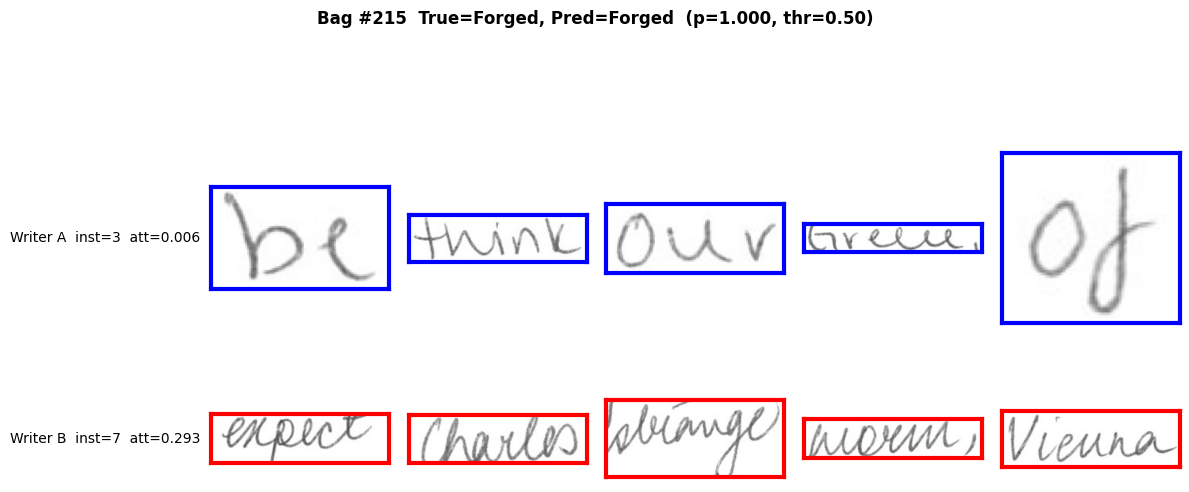

✓ saved: quick_reports/bag_215_A_vs_B.png

📊 Bag 215 요약:
   - 예측 확률: 1.0000
   - 실제 라벨: Forged (복수 작성자)
   - Top-3 attention: [0.29340613 0.23313881 0.22762385]

💡 해석: 위 그림에서 1행과 2행의 필기 스타일 차이를 눈으로 비교하세요.
   굵기/기울기/끝처리/간격 등이 명확히 다르면 → 복수 작성자(위조) 증거


In [5]:
# 5. 간단한 베이스라인 실행 - 한 장 그림으로 끝내기

print("🔍 확신 높은 Positive bag 자동 선택 후 한 장 리포트 생성...")

# 확신 높은 Positive bag 1개 자동 선택
picked = pick_positive_bag_indices(model, test_features, test_labels, metadata, threshold=0.5, topn=1)

if picked:
    bag_idx = picked[0]
    print(f"선택된 bag: {bag_idx} (확률 높은 Positive bag)")
    
    # 한 장 리포트 생성
    quick_positive_report(bag_idx, model, test_features, test_labels, metadata,
                          image_base=IMAGE_BASE_DIR, threshold=0.5, save_dir='quick_reports')
    
    # 간단한 정보 출력
    prob, att = _predict_att(model, test_features[bag_idx])
    print(f"\n📊 Bag {bag_idx} 요약:")
    print(f"   - 예측 확률: {prob:.4f}")
    print(f"   - 실제 라벨: {'Forged (복수 작성자)' if test_labels[bag_idx]==1 else 'Genuine (단일 작성자)'}")
    print(f"   - Top-3 attention: {np.sort(att)[-3:][::-1]}")
    print("\n💡 해석: 위 그림에서 1행과 2행의 필기 스타일 차이를 눈으로 비교하세요.")
    print("   굵기/기울기/끝처리/간격 등이 명확히 다르면 → 복수 작성자(위조) 증거")
    
else:
    print("❌ 예측이 Positive인 bag이 없습니다 (혹은 임계값이 너무 높음).")
    print("   임계값을 낮추거나 데이터를 확인해보세요.")

## 간단한 베이스라인 해석법

이 간단한 베이스라인은 복잡한 통계 분석 대신 **직관적인 시각 비교**에 집중합니다:

### 🎯 핵심 목표
- **한 장 그림**으로 Positive bag의 핵심만 보여주기
- **두 작성자의 대표 윈도우** 비교를 통한 직관적 판단

### 📊 해석 방법
1. **상단 정보**: Bag ID, 예측확률·임계값, 정답/예측 확인
2. **이미지 비교**: 
   - **1행**: Writer A의 Top-1 attention 윈도우 (파란 테두리)
   - **2행**: Writer B의 Top-1 attention 윈도우 (빨간 테두리)
3. **시각적 판단**: 두 행의 **획 굵기/기울기/끝처리/간격** 차이 확인

### ✅ 장점
- **직관성**: 전문가가 아니어도 눈으로 바로 확인 가능
- **속도**: 복잡한 계산 없이 즉시 결과 확인
- **명확성**: "다른 손"의 증거를 구체적 이미지로 제시

### 🔧 필요시 확장
- Top-K 윈도우로 확장 (현재는 Top-1만)
- 문서 좌표 맵핑으로 원문 하이라이트
- 여러 Positive bag 일괄 처리

> **핵심**: 이 베이스라인은 "해석의 복잡성"을 제거하고 **"눈으로 보는 증거"**에 집중합니다.